Epoch 1/80  loss=1.4963  val_loss=1.1848
Epoch 8/80  loss=0.3564  val_loss=0.4005
Epoch 16/80  loss=0.2513  val_loss=0.3338
Epoch 24/80  loss=0.2073  val_loss=0.3072
Epoch 32/80  loss=0.1784  val_loss=0.2862
Epoch 40/80  loss=0.1579  val_loss=0.2708
Epoch 48/80  loss=0.1420  val_loss=0.2592
Epoch 56/80  loss=0.1282  val_loss=0.2518
Epoch 64/80  loss=0.1180  val_loss=0.2428
Epoch 72/80  loss=0.1052  val_loss=0.2359
Epoch 80/80  loss=0.0955  val_loss=0.2334

Test Accuracy: 0.946

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       101
           1       0.97      0.92      0.94       101
           2       0.95      0.97      0.96        99
           3       0.92      0.97      0.95        99
           4       0.95      0.98      0.97       100

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



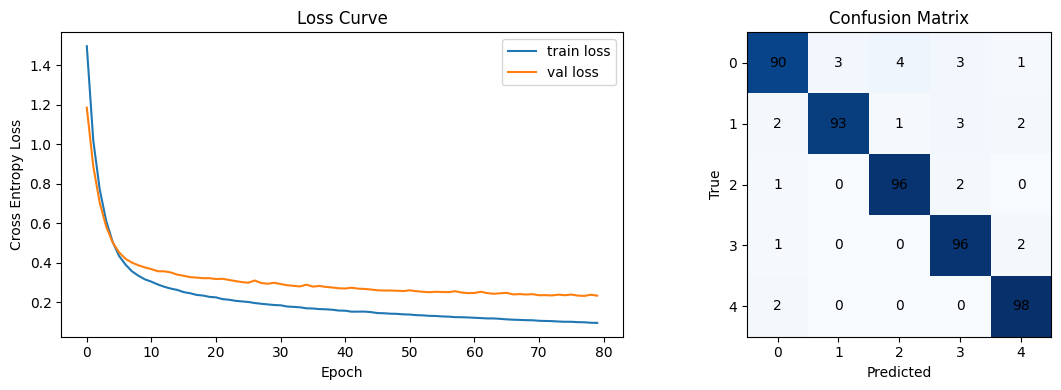

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd


# ---------------------------------------------------------
# 1) Generate dataset (5 classes, 12 features)
# ---------------------------------------------------------
np.random.seed(42)

X, y = make_classification(
    n_samples=2000,
    n_features=12,
    n_informative=10,
    n_redundant=0,
    n_classes=5,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


# ---------------------------------------------------------
# One-hot encoding
# ---------------------------------------------------------
def one_hot(y, n_classes):
    oh = np.zeros((y.size, n_classes))
    oh[np.arange(y.size), y] = 1
    return oh

y_train_oh = one_hot(y_train, 5)
y_test_oh = one_hot(y_test, 5)


# ---------------------------------------------------------
# 2) Neural Network (3 hidden layers) using NumPy
# ---------------------------------------------------------
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01, seed=1):
        np.random.seed(seed)
        self.params = {}
        dims = [input_dim] + hidden_dims + [output_dim]

        # Xavier initialization
        for i in range(1, len(dims)):
            fan_in, fan_out = dims[i-1], dims[i]
            limit = np.sqrt(6 / (fan_in + fan_out))
            self.params[f'W{i}'] = np.random.uniform(-limit, limit, (fan_in, fan_out))
            self.params[f'b{i}'] = np.zeros((1, fan_out))
        self.lr = lr

    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)

    @staticmethod
    def relu_grad(Z):
        return (Z > 0).astype(float)

    @staticmethod
    def softmax(Z):
        exp = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(probs, Y):
        N = probs.shape[0]
        clipped = np.clip(probs, 1e-12, 1.0)
        return -np.sum(Y * np.log(clipped)) / N

    # Forward pass
    def forward(self, X):
        cache = {'A0': X}
        L = len([k for k in self.params if k.startswith('W')])

        A = X
        for i in range(1, L):
            Z = A.dot(self.params[f'W{i}']) + self.params[f'b{i}']
            cache[f'Z{i}'] = Z
            A = self.relu(Z)
            cache[f'A{i}'] = A

        ZL = A.dot(self.params[f'W{L}']) + self.params[f'b{L}']
        cache[f'Z{L}'] = ZL
        probs = self.softmax(ZL)
        cache[f'A{L}'] = probs
        return probs, cache

    # Backpropagation
    def backward(self, cache, X, Y):
        grads = {}
        N = X.shape[0]
        L = len([k for k in self.params if k.startswith('W')])

        probs = cache[f'A{L}']
        dZ = (probs - Y) / N

        for i in reversed(range(1, L + 1)):
            A_prev = cache[f'A{i-1}']
            grads[f'dW{i}'] = A_prev.T.dot(dZ)
            grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True)

            if i > 1:
                dA_prev = dZ.dot(self.params[f'W{i}'].T)
                dZ = dA_prev * self.relu_grad(cache[f'Z{i-1}'])

        return grads

    def update_params(self, grads):
        L = len([k for k in self.params if k.startswith('W')])
        for i in range(1, L + 1):
            self.params[f'W{i}'] -= self.lr * grads[f'dW{i}']
            self.params[f'b{i}'] -= self.lr * grads[f'db{i}']

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)

    # Training
    def fit(self, X, Y, X_val=None, Y_val=None, epochs=100, batch_size=64, verbose=True):
        n = X.shape[0]
        history = {'loss': [], 'val_loss': []}

        for epoch in range(1, epochs + 1):
            perm = np.random.permutation(n)
            Xs, Ys = X[perm], Y[perm]
            epoch_loss = 0

            for i in range(0, n, batch_size):
                xb = Xs[i:i+batch_size]
                yb = Ys[i:i+batch_size]
                probs, cache = self.forward(xb)
                loss = self.cross_entropy_loss(probs, yb)
                epoch_loss += loss * xb.shape[0]
                grads = self.backward(cache, xb, yb)
                self.update_params(grads)

            epoch_loss /= n
            history['loss'].append(epoch_loss)

            if X_val is not None:
                val_probs, _ = self.forward(X_val)
                val_loss = self.cross_entropy_loss(val_probs, Y_val)
                history['val_loss'].append(val_loss)

            if verbose and (epoch % (epochs//10) == 0 or epoch == 1):
                print(f"Epoch {epoch}/{epochs}  loss={epoch_loss:.4f}  val_loss={val_loss:.4f}")

        return history


# ---------------------------------------------------------
# 3) Train model
# ---------------------------------------------------------
nn = NeuralNetwork(input_dim=12, hidden_dims=[64, 32, 16], output_dim=5, lr=0.05, seed=42)
history = nn.fit(X_train, y_train_oh, X_val=X_test, Y_val=y_test_oh,
                 epochs=80, batch_size=128, verbose=True)


# ---------------------------------------------------------
# 4) Evaluation
# ---------------------------------------------------------
y_pred = nn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nTest Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)


# ---------------------------------------------------------
# 5) Visualizations
# ---------------------------------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.legend()

plt.subplot(1,2,2)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()


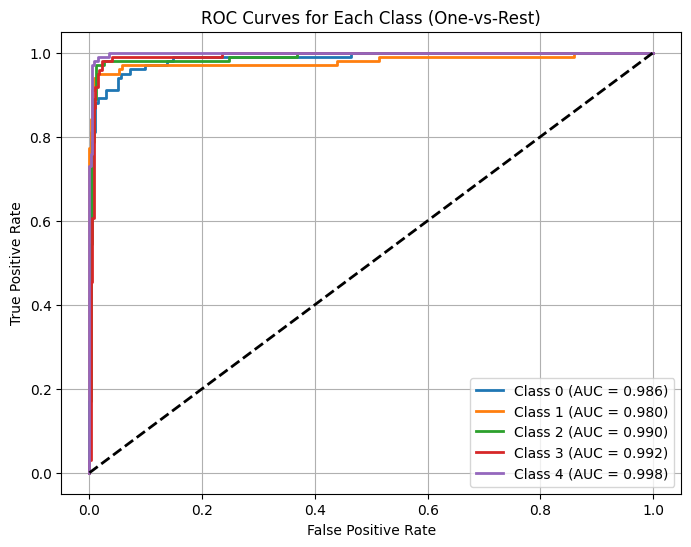

In [2]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities for test set
probs_test, _ = nn.forward(X_test)

# Plot ROC curves
plt.figure(figsize=(8,6))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curves for Each Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [4]:
print("Model configuration:")
print("Input features:", X_train.shape[1])
print("Hidden layers:", [64, 32, 16])
print("Output classes:", 5)
print("Learning rate:", nn.lr)
print("Epochs trained:", 80)



Model configuration:
Input features: 12
Hidden layers: [64, 32, 16]
Output classes: 5
Learning rate: 0.05
Epochs trained: 80
